# Temporal Analysis of SIF and XCO2
---

In [97]:
from numba import njit
import numpy as np
import pandas as pd
import xarray

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

In [2]:
from dask.distributed import Client
client = Client(n_workers=8, dashboard_address=":8889")
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:37579 Dashboard: http://127.0.0.1:8889/status,Cluster Workers: 8 Cores: 64 Memory: 270.51 GB


## Data processing

In [3]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew


def prep_xco2(ds):
    """Preprocess an FP Lite file"""
    
    # Drop unused variables
    variable_list = ["xco2", "xco2_quality_flag", "longitude", "latitude", "time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds = ds.where(ds.xco2_quality_flag == 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "xco2": (["time"], ds.xco2),
        },
        coords={
            "lon": (["time"], ds.longitude),
            "lat": (["time"], ds.latitude),
            "time": ds.time.values
        }
    )
    return dsnew

def aggregate_grid(ds):
    # Map lat-lon to 1-degree bins
    lon_bins = np.arange(-180, 181)
    lat_bins = np.arange(-85, 86)
    lon_centers = np.arange(-179.5, 180.5)
    lat_centers = np.arange(-84.5, 85.5)
    
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lon", "lat"]).mean().to_xarray()

In [4]:
# Open datasets for all years
paths_sif = "/data/OCO-2/OCO2_L2_Lite_SIF.10r/*/*.nc4"
paths_xco2 = "/data/OCO-2/OCO2_L2_Lite_FP.10r/*/*.nc4"

DS_sif = xarray.open_mfdataset(paths_sif, preprocess=prep_sif, 
                               parallel=True)
DS_xco2 = xarray.open_mfdataset(paths_xco2, preprocess=prep_xco2, 
                                parallel=True)

In [113]:
DS_sif

<xarray.Dataset>
Dimensions:  (time: 241812820)
Coordinates:
    lon      (time) float32 179.95068 179.57373 ... -178.81311 -178.76868
    lat      (time) float32 -18.5755 -16.785889 ... 71.71771 71.712036
  * time     (time) datetime64[ns] 2014-09-06T01:47:19.054687488 ... 2020-07-...
Data variables:
    sif      (time) float32 -0.12462711 0.0866375 ... 0.17045212 0.38776588

## Monthly time series comparison

In [175]:
# Compute monthly climatologies
df_sif = DS_sif.sif.resample(time="1MS").mean(dim="time").to_dataframe()
df_xco2 = DS_xco2.xco2.resample(time="1MS").mean(dim="time").to_dataframe()

# Merge dataframes
df = pd.merge(df_sif, df_xco2, how="outer", on=["time"]).reset_index()
# df["time"] = df.time.dt.strftime("%Y-%m")

df.head()

,time,sif,xco2
0,2014-09-01,0.168572,395.663696
1,2014-10-01,0.124161,396.069519
2,2014-11-01,0.075926,396.865021
3,2014-12-01,0.071579,397.389465
4,2015-01-01,0.080472,397.781097


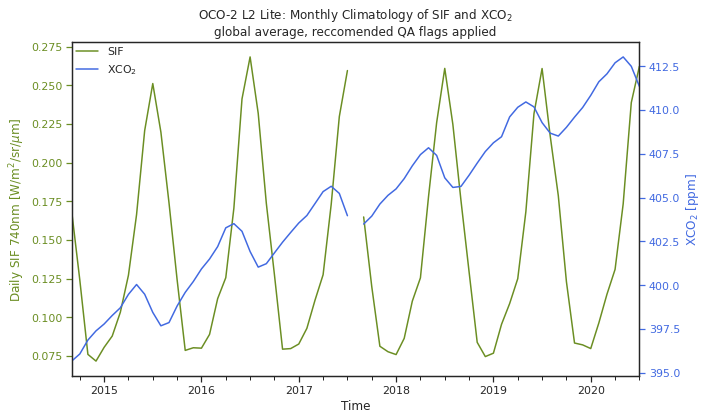

In [176]:
# Plot raw global average climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
# plt.savefig("../plots/monthly_climatology_comparison.png")

### Remove trend to study seasonality of anomalies

In [177]:
# Interpolate missing values
df_full = df.interpolate().set_index("time")

# Fit trends by least squares
X = (df_full.index - df_full.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_full.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_full.xco2).predict(X)

# Remove trends
df_full["sif_anom"] = df_full.sif - trend_sif
df_full["xco2_anom"] = df_full.xco2 - trend_xco2

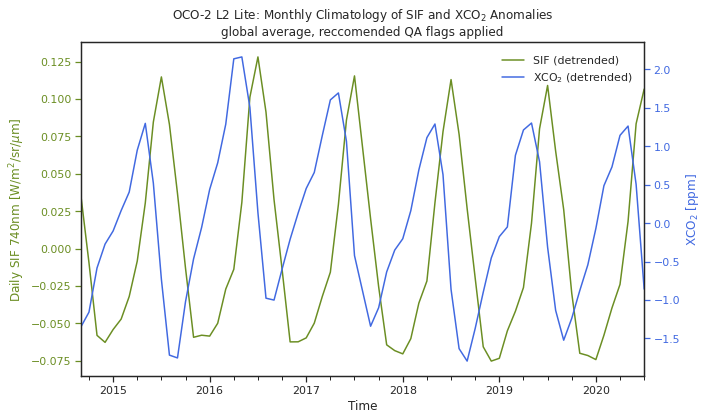

In [178]:
# Plot anomaly climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_full.plot(y="sif_anom", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
df_full.plot(y="xco2_anom", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$ Anomalies\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
# plt.savefig("../plots/monthly_climatology_detrended.png")

### Decompose series and look at correlation of residuals

In [92]:
df_full.set_index("time", inplace=True)

# Decompose each series
decomp_sif = sm.tsa.seasonal_decompose(df_full.sif)
decomp_xco2 = sm.tsa.seasonal_decompose(df_full.xco2)

# Merge data frames
df_resid = pd.merge(decomp_sif.resid, decomp_xco2.resid, how="inner", on=["time"])
df_resid.rename(columns={"resid_x": "SIF residual", "resid_y": "XCO2 residual"}, inplace=True);

In [93]:
sns.set_theme("notebook")

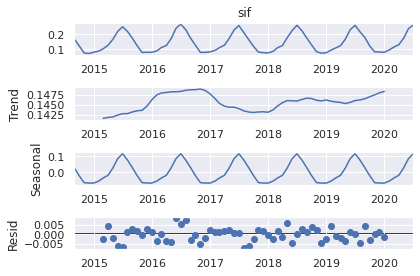

In [94]:
decomp_sif.plot();

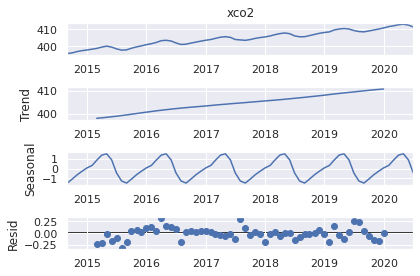

In [63]:
decomp_xco2.plot();

<Figure size 576x576 with 0 Axes>

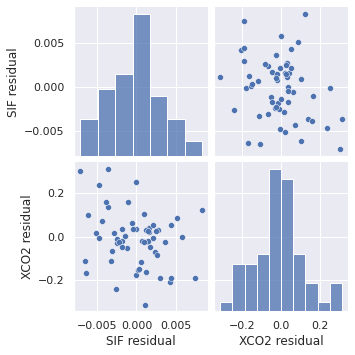

In [54]:
sns.pairplot(data=df_resid);

## Lagged analysis

In [24]:
# Lag in months
lag = 3

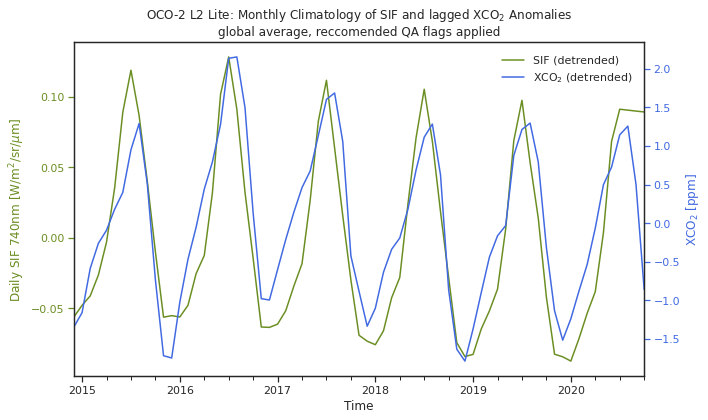

In [26]:
# Lagged climatology
df_sif = DS_sif.sif.resample(time="1MS").mean(dim="time").to_dataframe().reset_index()
df_xco2 = DS_xco2.xco2.resample(time="1MS").mean(dim="time").to_dataframe().reset_index()

df_xco2["time"] = pd.DatetimeIndex( df_xco2["time"] ) + pd.DateOffset(months = lag)

# Merge dataframes
df = pd.merge(df_sif, df_xco2, how="outer", on=["time"])

# Interpolate missing values
df_full = df.interpolate().set_index("time").dropna()

# Fit trends by least squares
X = (df_full.index - df_full.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_full.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_full.xco2).predict(X)

# Remove trends
df_full["sif_anom"] = df_full.sif - trend_sif
df_full["xco2_anom"] = df_full.xco2 - trend_xco2


sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_full.plot(y="sif_anom", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
df_full.plot(y="xco2_anom", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and lagged XCO$_2$ Anomalies\n"
              "global average, reccomended QA flags applied")

plt.tight_layout();

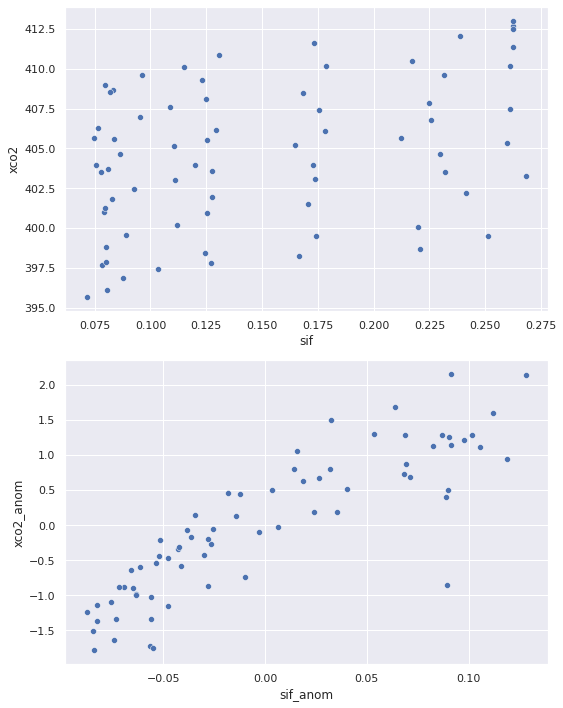

In [27]:
# Scatter plot of all global averages and anomalies
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

sns.scatterplot(x="sif", y="xco2", data=df_full, ax=ax1)
sns.scatterplot(x="sif_anom", y="xco2_anom", data=df_full, ax=ax2)

plt.tight_layout();

### Look at 1-degree lagged correlation

In [28]:
# Aggregate both datasets to 1-degree monthly averages
DS_sif_grid = DS_sif.resample(time="1MS").map(aggregate_grid)
DS_xco2_grid = DS_xco2.resample(time="1MS").map(aggregate_grid)

In [29]:
# Create data frame joining SIF and lagged XCO2 by coordinates
df_sif = DS_sif_grid.to_dataframe().dropna().reset_index()
df_xco2 = DS_xco2_grid.to_dataframe().dropna().reset_index()

# Apply months lag
df_xco2["time"] = pd.DatetimeIndex( df_xco2["time"] ) + pd.DateOffset(months = lag)

# Perform inner join
df = pd.merge(df_sif, df_xco2, how="inner", on=["lon", "lat", "time"])
df["time"] = df.time.dt.strftime("%Y-%m")
df.sort_values(by="time", inplace=True)

In [30]:
df.head()

,lat,lon,time,sif,xco2
164617,25.5,-100.5,2014-12,0.210840,395.711975
153856,22.5,18.5,2014-12,-0.011871,395.927216
153906,22.5,19.5,2014-12,-0.022469,395.906403
154047,22.5,25.5,2014-12,-0.038195,394.138550
154121,22.5,30.5,2014-12,0.007249,393.447479


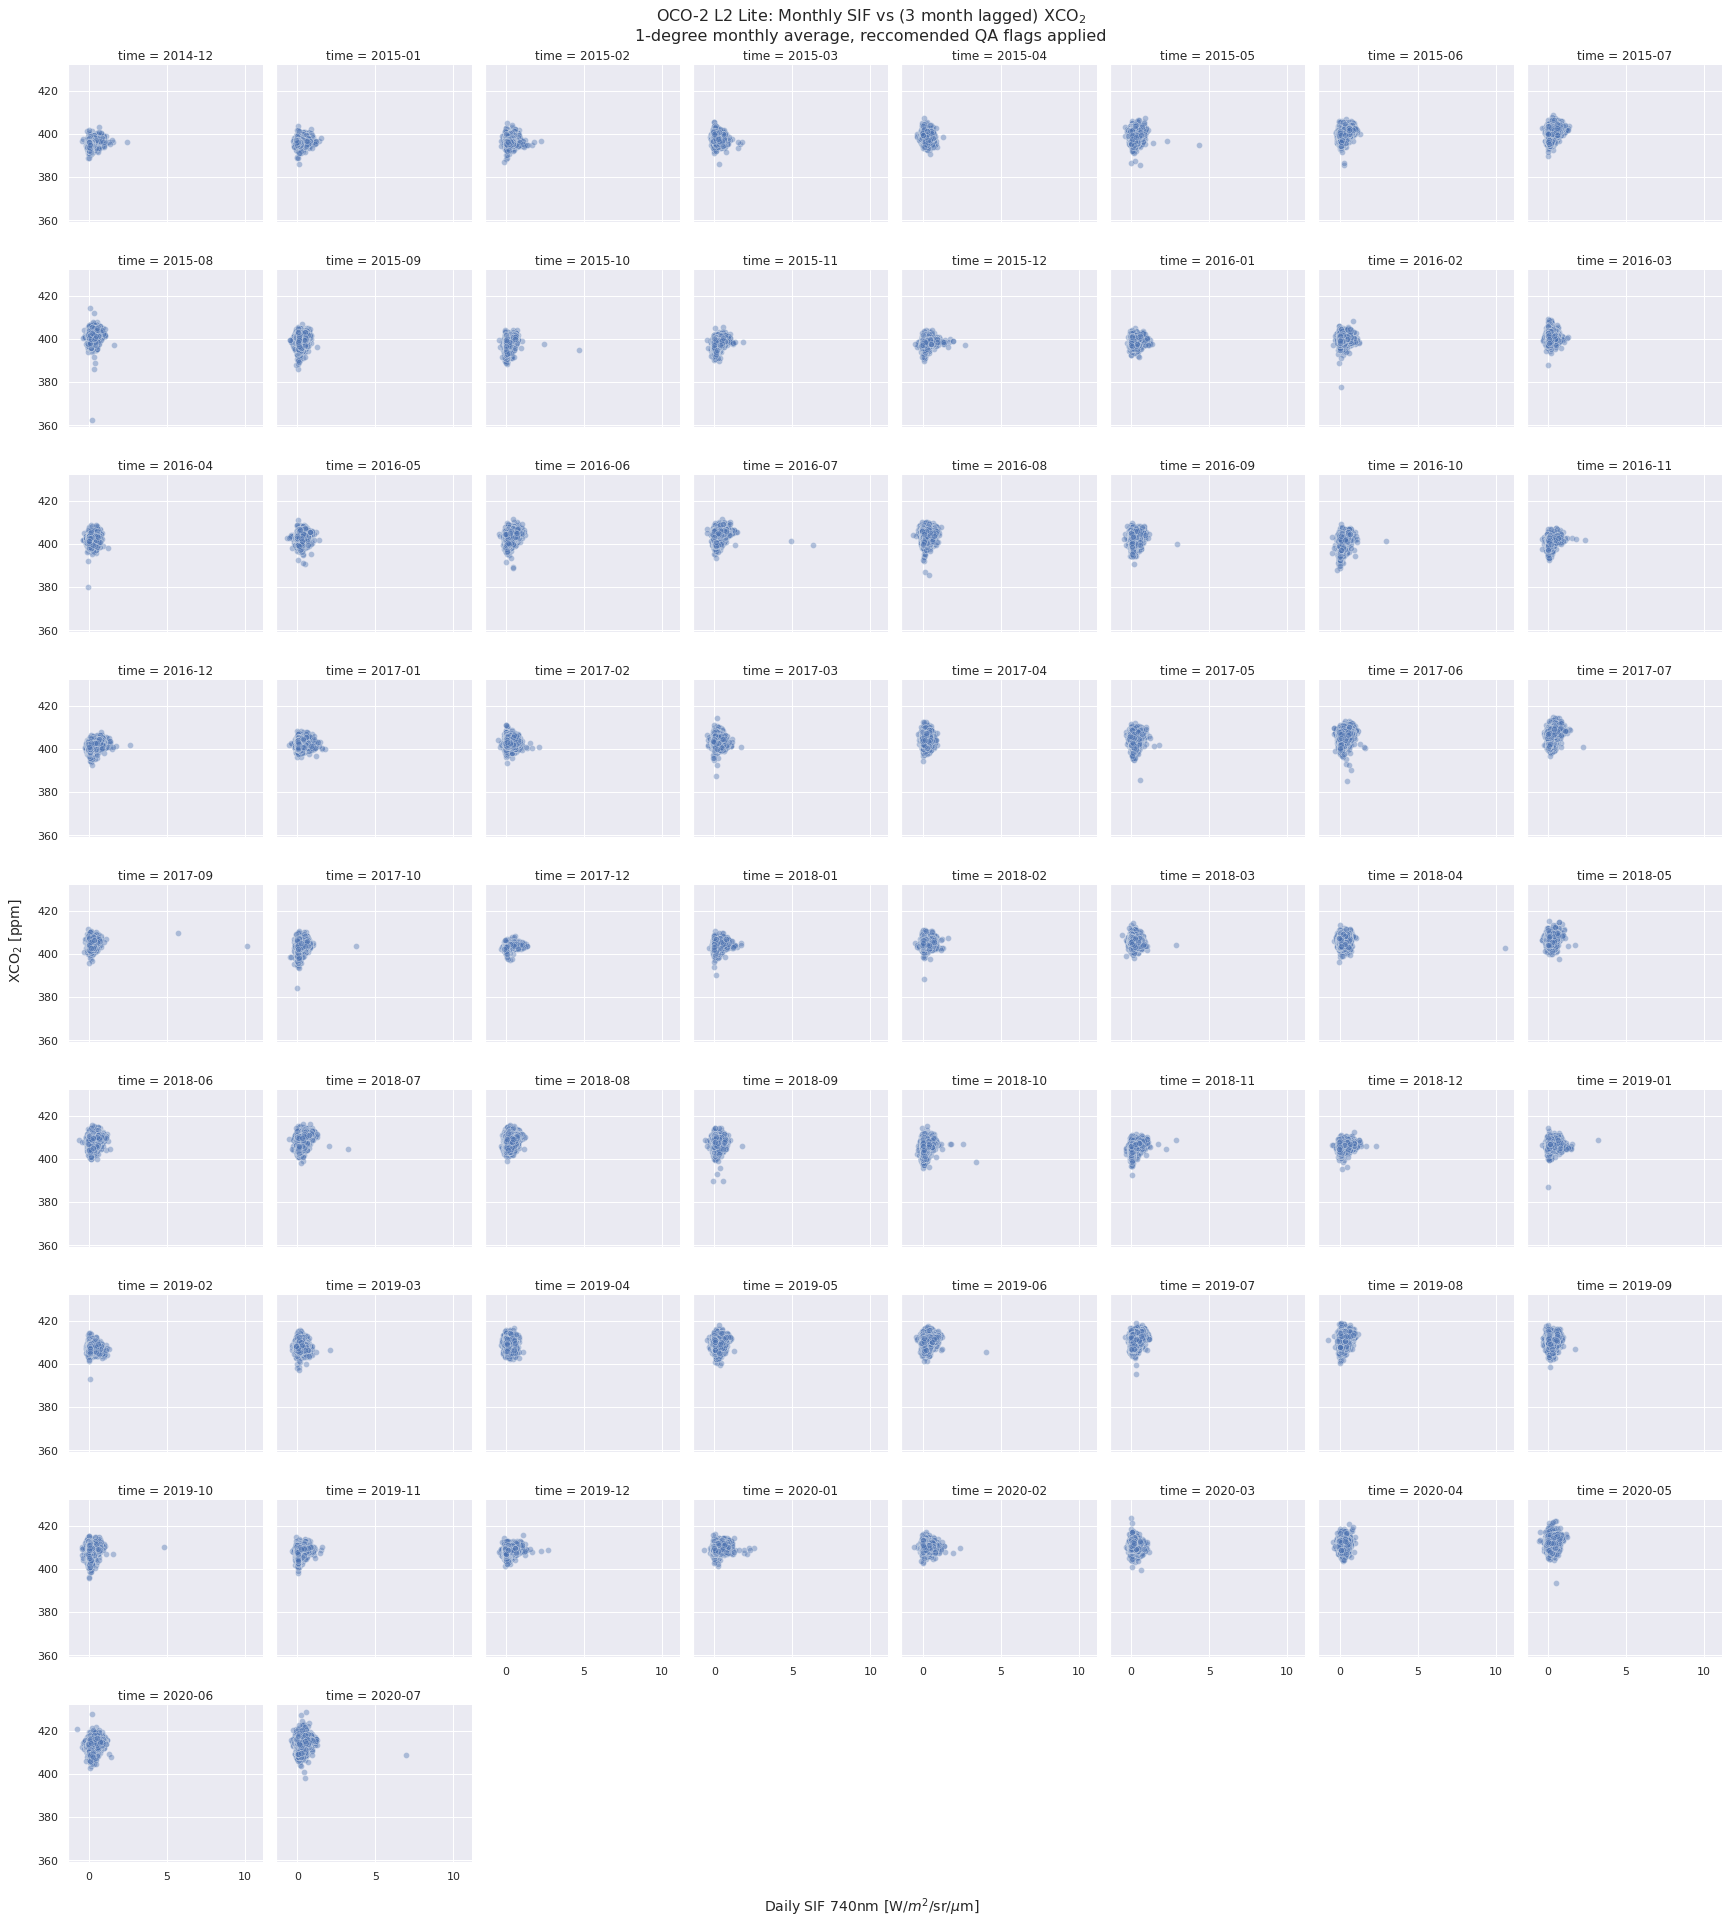

In [32]:
# Make scatter plots faceted by month
sns.set_theme()
g = sns.FacetGrid(df, col="time", col_wrap=8)
g.map(sns.scatterplot, "sif", "xco2", alpha=0.4)

plt.subplots_adjust(top=0.95)
g.fig.suptitle(f"OCO-2 L2 Lite: Monthly SIF vs ({lag} month lagged) XCO$_2$\n" 
               "1-degree monthly average, reccomended QA flags applied",
               size=16)

#this surpresses the x- and y-labels on each axes of the bottom/leftmost column
g.set_axis_labels("", "") 

# overall ylabel
g.fig.text(x=0, y=0.5, 
           verticalalignment="center",
           s="XCO$_2$ [ppm]",
           size=14,
           rotation=90)

#overall xlabel
g.fig.text(x=0.5, y=0, 
           horizontalalignment="center",
           s="Daily SIF 740nm [W/$m^2$/sr/$\mu$m]", 
           size=14)

plt.savefig("../plots/monthly_lagged_scatterplots.png")

## Regional analysis

In [264]:
@njit
def compute_xcov(v1, v2, lag):
    """
    Numba accelerated empirical cross-covariance
    Cressie and Wikle, Eq 5.4, single point.
    Parameters:
        - v1, v2: 1d numpy arrays
        - lag: integer lag in days
    Returns:
        - xcov: float
    """
    # truncate appropriate end of each vector to apply lag
    X = (v1 - v1.mean())[lag:]
    Y = (v2 - v2.mean())[:-lag]
    
    return np.dot(X, Y) / X.size

def compute_xcov_nd(v1, v2, lag):
    ## Could maybe improve speed if we can figure out how to broadcast
    ## Also consider avoiding ufunc, instead apply cross_cov to pandas groups
    """
    Numba accelerated empirical cross-covariance
    Cressie and Wikle, Eq 5.4, single point.
    Parameters:
        - v1, v2: n-d numpy arrays
        - lag: integer lag in days
    Returns:
        - xcov: float
    """
    # truncate along time dim at appropriate position to apply lag
    X = (v1 - v1.mean(axis=-1, keepdims=True))[:, :, lag:]
    Y = (v2 - v2.mean(axis=-1, keepdims=True))[:, :, :-lag]
    
    return np.dot(X, Y) / X.size

def cross_covariance(v1, v2, lag=0):
    """
    Wrapper function to check conditions and run computation if possible.
    """
    # Remove NaN elements
    v1 = v1[np.isfinite(v1)]
    v2 = v2[np.isfinite(v2)]
    
    if v1.size == v2.size and v1.size > lag:
        return compute_xcov(v1, v2, lag)
    else:
        return np.nan
    
def apply_cross_covariance(x, y, lag=0):
    return xarray.apply_ufunc(
        cross_covariance,
        x,
        y,
        kwargs = {"lag": lag},
        input_core_dims = [["time"], ["time"]],
        dask = "parallelized",
        vectorize = True,
        output_dtypes = [float],
    )

In [255]:
a = np.arange(2 * 2 * 10).reshape((2, 2, 10))
b = np.arange(2 * 2 * 10).reshape((2, 2, 10))

print(a)
a.sum(axis=-1)

[[[ 0  1  2  3  4  5  6  7  8  9]
  [10 11 12 13 14 15 16 17 18 19]]

 [[20 21 22 23 24 25 26 27 28 29]
  [30 31 32 33 34 35 36 37 38 39]]]


array([[ 45, 145],
       [245, 345]])

In [261]:
np.tensordot(a, b, axes=([-1], [-1]))

array([[[[  285,   735],
         [ 1185,  1635]],

        [[  735,  2185],
         [ 3635,  5085]]],


       [[[ 1185,  3635],
         [ 6085,  8535]],

        [[ 1635,  5085],
         [ 8535, 11985]]]])

In [179]:
## Analyze a single cell

# Setup regional masks
region_sif = (
    (DS_sif.coords["lat"] >= 39)
    & (DS_sif.coords["lat"] < 40)
    & (DS_sif.coords["lon"] <= -89)
    & (DS_sif.coords["lon"] < -90)
)
region_xco2 = (
    (DS_xco2.coords["lat"] >= 39)
    & (DS_xco2.coords["lat"] < 40)
    & (DS_xco2.coords["lon"] <= -89)
    & (DS_xco2.coords["lon"] < -90)
)

# Select values in regional and compute daily average
df_region_sif = DS_sif.sif.where(region_sif, drop=True).resample(time="1D").mean(dim="time").to_dataframe().reset_index()
df_region_xco2 = DS_xco2.xco2.where(region_xco2, drop=True).resample(time="1D").mean(dim="time").to_dataframe().reset_index()

# Apply months lag
# df_region_xco2["time"] = pd.DatetimeIndex( df_region_xco2["time"] ) + pd.DateOffset(months = 2)

# Merge dataframes
df_region = pd.merge(df_region_sif, df_region_xco2, how="inner", on=["time"]).dropna()
df_region

## NOTE: seems like there's some serious missing data (365*6=2190)

,time,sif,xco2
0,2014-09-07,0.419197,392.943848
3,2014-09-10,0.231892,393.473999
4,2014-09-11,0.019689,394.602448
7,2014-09-14,0.354859,393.015381
8,2014-09-15,0.157048,394.473206
...,...,...,...
2148,2020-07-25,0.012569,412.716095
2149,2020-07-26,0.914736,411.605530
2150,2020-07-27,0.191499,412.241913
2151,2020-07-28,0.477579,412.425079


In [265]:
cross_covariance(df_region.sif.values, df_region.xco2.values, lag=90)

0.19694960891200539

### Compute cross covariance for each 1-degree cell and map values

In [188]:
def regrid(ds):
    """
    Convert dataset to dataframe and assign coordinates to 1-degree grid boxes.
    """
    # Map lat-lon to 1-degree bins
    lon_bins = np.arange(-180, 181)
    lat_bins = np.arange(-85, 86)
    lon_centers = np.arange(-179.5, 180.5)
    lat_centers = np.arange(-84.5, 85.5)
    
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)
    
    return df

In [193]:
# Cut datasets to a regular grid and resample to daily averages within each grid cell
df_sif_daily = regrid(DS_sif).groupby(["lon", "lat"]).resample("1D").mean().drop(columns=["lon", "lat"]).dropna()
df_xco2_daily = regrid(DS_xco2).groupby(["lon", "lat"]).resample("1D").mean().drop(columns=["lon", "lat"]).dropna()

# Perform inner join and convert to dataset
DS_grid_daily = pd.merge(df_sif_daily, df_xco2_daily, how="inner", on=["lon", "lat", "time"]).to_xarray()

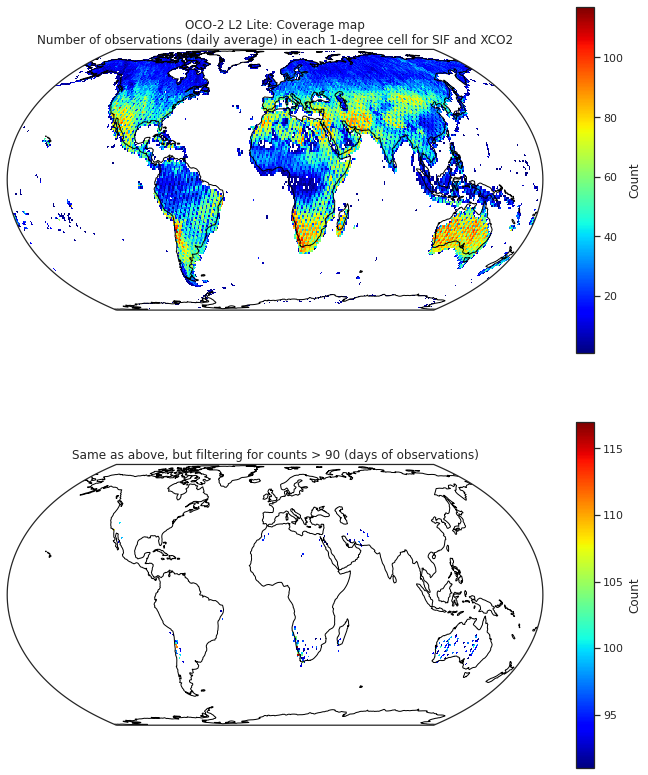

In [291]:
# Generate a coverage maps (standard and one filtering over 90 days)
DS_daily_counts = pd.merge(df_sif_daily, df_xco2_daily, how="inner", on=["lon", "lat", "time"]).groupby(["lon", "lat"]).count().to_xarray()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), subplot_kw={"projection": ccrs.EqualEarth()})

ax1.set_global()
xarray.plot.imshow(DS_daily_counts.sif.T, transform=ccrs.PlateCarree(),
                   cmap="jet", cbar_kwargs={"label": "Count"}, ax=ax1)
ax1.coastlines()
ax1.set_title("OCO-2 L2 Lite: Coverage map\n" 
              "Number of observations (daily average) in each 1-degree cell for SIF and XCO2")

ax2.set_global()
xarray.plot.imshow(DS_counts.sif.where(DS_counts.sif > 90).T, transform=ccrs.PlateCarree(),
                   cmap="jet", cbar_kwargs={"label": "Count"}, ax=ax2)
ax2.coastlines()
ax2.set_title("Same as above, but filtering for counts > 90 (days of observations)")

plt.savefig("../plots/coverage_map_1degree_daily.png")

In [266]:
# Map cross covariance function to each grid cell (maybe chunk dimensions first)
DS_xcov = apply_cross_covariance(DS_grid_daily.sif, DS_grid_daily.xco2, lag=90)